In [ ]:
%matplotlib inline


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].
<div class="alert alert-info"><h4>Note</h4><p>If running on Windows and you get a BrokenPipeError, try setting
    the num_worker of torch.utils.data.DataLoader() to 0.</p></div>



In [2]:
"""
由于torchvision的datasets的输出是[0,1]的PILImage，
所以我们先先归一化为[-1,1]的Tensor.
首先定义了一个变换transform，利用的是上面提到的transforms模块中的Compose( )
把多个变换组合在一起，可以看到这里面组合了ToTensor和Normalize这两个变换
"""

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

"""
Normalize对每个通道执行以下操作：
image = (image - mean) / std
参数mean, std以0.5或0.5的形式传递。这将使图像在[-1,1]范围内归一化。
例如，最小值0将转换为(0-0.5)/0.5=-1，最大值1将转换为(1-0.5)/0.5=1.
如果您想将图像恢复到[0,1]范围，则可以使用，
image = ((image * std) + mean)


https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize
两个参数都是“每个通道的序列”。彩色图像具有三个通道（红色，绿色，蓝色），
因此您需要三个参数来标准化每个通道。
第一个元组（0.5，0.5，0.5）是所有三个通道的平均值，第二个元组（0.5，0.5，0.5）是所有三个通道的标准偏差。
"""



"""
定义了我们的训练集，名字就叫trainset，至于后面这一堆，其实就是一个类：
torchvision.datasets.CIFAR10( )也是封装好了的，就在我前面提到的torchvision.datasets
模块中,不必深究，如果想深究就看我这段代码后面贴的图1，其实就是在下载数据
（不翻墙可能会慢一点吧）然后进行变换，可以看到transform就是我们上面定义的transform
"""
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)





"""
trainloader其实是一个比较重要的东西，我们后面就是通过trainloader把数据传入网
络，当然这里的trainloader其实是个变量名，可以随便取，重点是他是由后面的
torch.utils.data.DataLoader()定义的，这个东西来源于torch.utils.data模块，
网页链接http://pytorch.org/docs/0.3.0/data.html，这个类可见我后面图2
"""
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=0)
#shuffle 为是否打乱


# 对于测试集的操作和训练集一样，不再赘述了
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=0)
# num_workers> 0不适用于Windows



# 类别信息也是需要我们给定的
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



In [3]:
import matplotlib.pyplot as plt
import numpy as np
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize ,见上个代码块的normalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
"""
np.transpose方法介绍
>>> x = np.ones((1, 2, 3))
>>> np.transpose(x, (1, 0, 2)).shape
(2, 1, 3)
"""

# get some random training images
dataiter = iter(trainloader)   #iter()函数用来生成迭代器
images, labels = dataiter.next()  #next()返回迭代器的下一个项目

# print("images:",labels, "labels:",labels)
# images: tensor([1, 2, 8, 9]) labels: tensor([1, 2, 8, 9])

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

<Figure size 640x480 with 1 Axes>

plane truck   dog   car


2. Define a Convolutional Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



torch.nn中大多数layer在torch.nn.funtional中都有一个与之对应的函数。二者的区别在于：

`torch.nn.Module`中实现layer的都是一个特殊的类，可以去查阅，他们都是以class xxxx来定义的，会自动提取可学习的参数

而`nn.functional`中的函数，更像是纯函数，由def function( )定义，只是进行简单的数学运算而已。

说到这里你可能就明白二者的区别了，`functional中的函数是一个确定的不变的运算公式，输入数据产生输出就ok`，

而深度学习中会有很多权重是在不断更新的，不可能每进行一次forward就用新的权重重新来定义一遍函数来进行计算，所以说就会采用类的方式，以确保能在参数发生变化时仍能使用我们之前定好的运算步骤。

所以从这个分析就可以看出什么时候改用nn.Module中的layer了：

`如果模型有可学习的参数，最好使用nn.Module对应的相关layer`，否则二者都可以使用，没有什么区别。

比如此例中的Relu其实没有可学习的参数，只是进行一个运算而已，所以使用的就是functional中的relu函数，

而卷积层和全连接层都有可学习的参数，所以用的是nn.Module中的类。

不具备可学习参数的层，将它们用函数代替，这样可以不用放在构造函数中进行初始化。


In [4]:
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable 

# 我们定义网络时一般是继承的torch.nn.Module创建新的子类
class Net(nn.Module):  
    def __init__(self):
        super(Net, self).__init__() 
        # 第二、三行都是python类继承的基本操作,
        # 此写法应该是python2.7的继承格式,但python3里写这个好像也可以
        
        # 定义conv1函数的是图像卷积函数：输入为图像（3个频道，即灰度图）,输出为 6张特征图, 卷积核为5x5正方形
        self.conv1 = nn.Conv2d(3, 6, 5)
        
        # 使用2x2的窗口进行最大池化Max pooling
        self.pool = nn.MaxPool2d(2, 2)
        
        # 定义conv2函数的是图像卷积函数：输入为6张特征图,输出为16张特征图, 卷积核为5x5正方形
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # 定义fc1（fullconnect）全连接函数1为线性函数：y = Wx + b，并将16*5*5个节点连接到120个节点上
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        
        #定义fc2（fullconnect）全连接函数2为线性函数：y = Wx + b，并将120个节点连接到84个节点上
        self.fc2 = nn.Linear(120, 84)
        
        #定义fc2（fullconnect）全连接函数2为线性函数：y = Wx + b，并将84个节点连接到10个节点上
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        #输入x经过卷积conv1之后，经过激活函数ReLU，进行最大池化Max pooling，然后更新到x
        x = self.pool(F.relu(self.conv1(x)))
        
        #输入x经过卷积conv2之后，经过激活函数ReLU，进行最大池化Max pooling，然后更新到x
        x = self.pool(F.relu(self.conv2(x)))
        
        
        """
         .view( )是一个tensor的方法，使得tensor改变size但是元素的总数是不变的。
        第一个参数-1是说这个参数由另一个参数确定， 
        比如矩阵在元素总数一定的情况下，确定列数就能确定行数。
        那么为什么这里只关心列数不关心行数呢，因为马上就要进入全连接层了，
        而全连接层说白了就是矩阵乘法，你会发现第一个全连接层的首参数是16*5*5，
        所以要保证能够相乘，在矩阵乘法之前就要把x调到正确的size
        更多的Tensor方法参考Tensor: http://pytorch.org/docs/0.3.0/tensors.html
        
        """
        x = x.view(-1, 16 * 5 * 5)
        
        
        
        #输入x经过全连接1，再经过ReLU激活函数，然后更新x
        x = F.relu(self.fc1(x))
        
        #输入x经过全连接2，再经过ReLU激活函数，然后更新x
        x = F.relu(self.fc2(x))
        
        #输入x经过全连接3，然后更新x
        x = self.fc3(x)
        return x

# 和python中一样，类定义完之后实例化就很简单了，我们这里就实例化了一个net
net = Net()

3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



pytorch将深度学习中常用的优化方法全部封装在torch.optim之中，所有的优化方法都是继承基类optim.Optimizier

In [5]:
import torch.optim as optim  #导入torch.potim模块

#同样是用到了神经网络工具箱 nn 中的交叉熵损失函数
criterion = nn.CrossEntropyLoss()  

#optim模块中的SGD梯度优化方式---随机梯度下降
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)  #(参数，学习率，动量)

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [6]:
for epoch in range(2):  # 指定要训练的epoch

    running_loss = 0.0  # 定义一个变量方便我们对loss进行输出
    for i, data in enumerate(trainloader, 0):
        # 使用前面定义的trainloader进行数据输入
        # enumerate是python的内置函数，既获得索引也获得数据
        """
        >>>seasons = ['Spring', 'Summer', 'Fall', 'Winter']
        >>> list(enumerate(seasons))
        [(0, 'Spring'), (1, 'Summer'), (2, 'Fall'), (3, 'Winter')]
        >>> list(enumerate(seasons, start=1))       # 下标从 1 开始
        [(1, 'Spring'), (2, 'Summer'), (3, 'Fall'), (4, 'Winter')]
        """
        
        ## data是从enumerate返回的data，包含数据和标签信息，分别赋值给inputs和labels
        inputs, labels = data
        
        # 要把梯度重新归零，因为反向传播过程中梯度会累加上一次循环的梯度
        optimizer.zero_grad()   

        # forward + backward + optimize
        
        # 把数据输进网络net，这个net()在第二步的代码最后一行我们已经定义了
        outputs = net(inputs)
        
        # 损失函数计算损失值，criterion我们在第三步里面定义了
        loss = criterion(outputs, labels)
        
        # loss进行反向传播
        loss.backward()
        
        # 反向传播完之后利用loss值进行权值调整，把优化器的参数进行更新，以便进行下一轮
        optimizer.step()

        # print结果
        running_loss += loss.item()
        # 从下面一行代码可以看出它是每循环0-1999共两千次才打印一次，所以每个2000次之类先用running_loss进行累加
        if i % 2000 == 1999:   
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))  # 然后再除以2000，就得到这两千次的平均损失值
            # 这一个2000次结束后，就把running_loss归零，下一个2000次继续使用
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.286
[1,  4000] loss: 1.957
[1,  6000] loss: 1.725
[1,  8000] loss: 1.590
[1, 10000] loss: 1.551
[1, 12000] loss: 1.483
[2,  2000] loss: 1.425
[2,  4000] loss: 1.406
[2,  6000] loss: 1.382
[2,  8000] loss: 1.386
[2, 10000] loss: 1.326
[2, 12000] loss: 1.326
Finished Training


Let's quickly save our trained model:



In [7]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

See `here <https://pytorch.org/docs/stable/notes/serialization.html>`_
for more details on saving PyTorch models.

5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



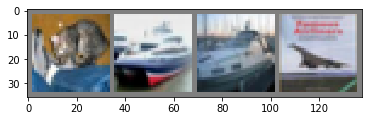

GroundTruth:    cat  ship  ship plane


In [8]:
 # 创建一个python迭代器，读入的是我们第一步里面就已经加载好的testloader
dataiter = iter(testloader) 

 # 返回一个batch_size的图片，根据第一步的设置，应该是4张
images, labels = dataiter.next()

 # 展示这四张图片
imshow(torchvision.utils.make_grid(images))

# python字符串格式化 ' '.join表示用空格来连接后面的字符串，参考python的join（）方法
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

接下来，让我们重新加载保存的模型（注意：这里不需要保存和重新加载模型，我们只是为了说明如何这样做）：

In [9]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

好的，现在让我们看看神经网络如何看待以上这些示例：

In [10]:
outputs = net(images)  # 注意这里的images是我们从上面获得的那四张图片

输出是10类的能量。一个类别的能量越高，网络就认为该图像属于特定类别。因此，让我们获得最高能量的指数

In [11]:
_, predicted = torch.max(outputs, 1) # 寻找outputs中每行最大的数，按一维的方式进行输出，输出为两列，我们只要第二列，不需要第二列

#具体解释在https://blog.csdn.net/teeyohuang/article/details/79222857
# 这个 _ , predicted是python的一种常用的写法，表示后面的函数其实会返回两个值
# 但是我们对第一个值不感兴趣，就写个_在那里，把它赋值给_就好，我们只关心第二个值predicted
# 比如 _ ,a = 1,2 这中赋值语句在python中是可以通过的，你只关心后面的等式中的第二个位置的值是多少


# python的字符串格式化
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship truck  ship


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [12]:
correct = 0   # 定义预测正确的图片数，初始化为0
total = 0     # 总共参与测试的图片数，也初始化为0

"""
为了防止跟踪历史（和使用内存），你还可以用“with torch.no_grad(): ”来包装代码块。
这在评估一个模型时特别有用，因为模型可能有可训练参数（具有属性“requiresgrad=True”）
但我们并不需要整个模型的所有梯度。

在测试的时候 禁止梯度计算，防止在测试的时候 测试集对模型的参数进行优化，改变了测试前的模型，从而影响了最终的结果.
"""

with torch.no_grad():
    for data in testloader:  # 循环每一个batch
        images, labels = data 
        outputs = net(images)  
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)  # 每次的batchsize
        # print(labels.size(0)) 
        correct += (predicted == labels).sum().item()  # 更新正确分类的图片的数量

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %


That looks way better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [18]:
# 定义一个存储每类中测试正确的个数的 列表，初始化为0
class_correct = list(0. for i in range(10))

# 定义一个存储每类中测试总数的个数的 列表，初始化为0
class_total = list(0. for i in range(10))

#[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 结果为初始化10个0.0

#禁止梯度下降
with torch.no_grad():
    for data in testloader:  #以一个batch为单位进行循环
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()  #删除维度
        #print("c.shape = ",c.shape)
        #print("c = ",c)
        for i in range(4):  # 因为每个batch都有4张图片，所以还需要一个4的小循环
            label = labels[i]    # 对各个类的进行各自累加
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 38 %
Accuracy of   car : 60 %
Accuracy of  bird : 56 %
Accuracy of   cat : 16 %
Accuracy of  deer : 40 %
Accuracy of   dog : 37 %
Accuracy of  frog : 75 %
Accuracy of horse : 69 %
Accuracy of  ship : 66 %
Accuracy of truck : 73 %


Okay, so what next?

How do we run these neural networks on the GPU?

Training on GPU
----------------
Just like how you transfer a Tensor onto the GPU, you transfer the neural
net onto the GPU.

Let's first define our device as the first visible cuda device if we have
CUDA available:



In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


The rest of this section assumes that ``device`` is a CUDA device.

Then these methods will recursively go over all modules and convert their
parameters and buffers to CUDA tensors:

.. code:: python

    net.to(device)


Remember that you will have to send the inputs and targets at every step
to the GPU too:

.. code:: python

        inputs, labels = data[0].to(device), data[1].to(device)

Why dont I notice MASSIVE speedup compared to CPU? Because your network
is really small.

**Exercise:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.

**Goals achieved**:

- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images

Training on multiple GPUs
-------------------------
If you want to see even more MASSIVE speedup using all of your GPUs,
please check out :doc:`data_parallel_tutorial`.

Where do I go next?
-------------------

-  :doc:`Train neural nets to play video games </intermediate/reinforcement_q_learning>`
-  `Train a state-of-the-art ResNet network on imagenet`_
-  `Train a face generator using Generative Adversarial Networks`_
-  `Train a word-level language model using Recurrent LSTM networks`_
-  `More examples`_
-  `More tutorials`_
-  `Discuss PyTorch on the Forums`_
-  `Chat with other users on Slack`_


